In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Import Preprocessed Data

In [2]:
data = pickle.load( open( "data.pkl", "rb" ) )
X_train, y_train, X_val, y_val, X_test, y_test = data

/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


### Define Model

In [3]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 256
        self.num_heads = 1
        self.num_jet_feats = 3
        self.num_trk_feats = 6
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.jet_trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
            
        self.multihead_attn_jet_trk = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)        
        self.jet_postprocess = nn.Linear(self.embed_dim*2, self.embed_dim)
       
        self.multihead_attn_trk = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)        
        self.cross_post_layer_norm = nn.LayerNorm(self.embed_dim)
        self.cross_combined_layer_norm = nn.LayerNorm(self.embed_dim)
        self.cross_post_process = nn.Linear(self.embed_dim, self.embed_dim)

        self.multihead_attn_jet = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)        
        self.jet_post_layer_norm = nn.LayerNorm(self.embed_dim)
        self.jet_combined_layer_norm = nn.LayerNorm(self.embed_dim)
        self.jet_post_process = nn.Linear(self.embed_dim, self.embed_dim)

        self.post_process1 = nn.Linear(self.embed_dim, self.embed_dim*8)
        self.post_process2 = nn.Linear(self.embed_dim*8, self.embed_dim)
        self.regression = nn.Linear(self.embed_dim, 1)
        
    def forward(self, jets, jet_trks, trks):
        # Feature preprocessing layers
        jet_init = F.relu(self.jet_initializer(jets))
        jet_trk_init = F.relu(self.jet_trk_initializer(jet_trks))
        trk_init = F.relu(self.trk_initializer(trks))
        
        # Calculate aggregated tracks using attention
        query = jet_trk_init
        key = jet_trk_init
        value = jet_trk_init
        jet_trk_embedding, trk_weights = self.multihead_attn_jet_trk(query, key, value)
        
        # Generate meaningful jet_embedding using info from trk_aggregated  
        jet_trk_aggregated = jet_trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, jet_trk_aggregated),1)
        jet_embedding = F.relu(self.jet_postprocess(jet_embedding))

        # Cross Attention
        query = jet_embedding
        key = trk_init
        value = trk_init
        jet_attention, cross_weights = self.multihead_attn_trk(query, key, value)
        jet_attention = self.cross_post_layer_norm(jet_attention)
        jet_embedding = jet_embedding + jet_attention
        jet_embedding = self.cross_combined_layer_norm(jet_embedding)
        jet_embedding = F.relu(self.cross_post_process(jet_embedding))
        
        # Update embeddings of jets in the contex of entire event
        query = jet_embedding
        key = jet_embedding
        value = jet_embedding
        jet_attention, jet_weights = self.multihead_attn_jet(query, key, value)
        jet_attention = self.jet_post_layer_norm(jet_attention)
        jet_embedding = jet_embedding + jet_attention
        jet_embedding = self.jet_combined_layer_norm(jet_embedding)
        jet_embedding = F.relu(self.jet_post_process(jet_embedding))
        
        # Get output
        jet_embedding = F.relu(self.post_process1(jet_embedding))
        jet_embedding = F.relu(self.post_process2(jet_embedding))
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, jet_weights, trk_weights, cross_weights

In [4]:
# Get Instance of the model
model = Model()
print(model)
print()

# Pass some data to the model and print outputs
Event_no = 0
Jets    = 0
Trk_Jet = 1
Trks     = 2
output, jet_weights, trk_weights, cross_weights = model(X_train[Event_no][Jets],X_train[Event_no][Trk_Jet],X_train[Event_no][Trks])
print(output.shape)
print(jet_weights.shape)
print(trk_weights.shape)
print(cross_weights.shape)

# Evaluate the loss
loss_fn = nn.MSELoss()
print(loss_fn(output,y_train[Event_no]))

Model(
  (jet_initializer): Linear(in_features=3, out_features=256, bias=True)
  (jet_trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (multihead_attn_jet_trk): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (jet_postprocess): Linear(in_features=512, out_features=256, bias=True)
  (multihead_attn_trk): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (cross_post_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (cross_combined_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (cross_post_process): Linear(in_features=256, out_features=256, bias=True)
  (multihead_attn_jet): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (jet_post_layer_norm): L

### Define Training Loop

In [5]:
def train(model, X_train, y_train, X_val, y_val, epochs=40):
    
    combined_history = []
    
    num_train = len(X_train)
    num_val = len(X_val)
    
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0

        for i in range(num_train):
            optimizer.zero_grad()
            
            output, jet_weights, trk_weights, cross_weights = model(X_train[i][0].to(device), X_train[i][1].to(device), X_train[i][2].to(device))
            
            loss=loss_fn(output, y_train[i].to(device))
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        for i in range(num_val):
            output, jet_weights, trk_weights, cross_weights = model(X_val[i][0].to(device), X_val[i][1].to(device), X_val[i][2].to(device))
            loss=loss_fn(output, y_val[i].to(device))
            
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_val = cumulative_loss_val / num_val

        combined_history.append([cumulative_loss_train, cumulative_loss_val])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return np.array(combined_history)

### Train Model

GPU Available:  True
cuda:0

Epoch: 0 	Train Loss: 0.163948 	Val Loss: 0.138991
Epoch: 1 	Train Loss: 0.125843 	Val Loss: 0.112082
Epoch: 2 	Train Loss: 0.092421 	Val Loss: 0.076421
Epoch: 3 	Train Loss: 0.064324 	Val Loss: 0.058864
Epoch: 4 	Train Loss: 0.053877 	Val Loss: 0.05324
Epoch: 5 	Train Loss: 0.050411 	Val Loss: 0.050916
Epoch: 6 	Train Loss: 0.048526 	Val Loss: 0.049378
Epoch: 7 	Train Loss: 0.047449 	Val Loss: 0.048687
Epoch: 8 	Train Loss: 0.046592 	Val Loss: 0.047878
Epoch: 9 	Train Loss: 0.045998 	Val Loss: 0.047469
Epoch: 10 	Train Loss: 0.045665 	Val Loss: 0.047193
Epoch: 11 	Train Loss: 0.045272 	Val Loss: 0.046913
Epoch: 12 	Train Loss: 0.044995 	Val Loss: 0.046515
Epoch: 13 	Train Loss: 0.044747 	Val Loss: 0.046384
Epoch: 14 	Train Loss: 0.044586 	Val Loss: 0.046352
Epoch: 15 	Train Loss: 0.044386 	Val Loss: 0.046379
Epoch: 16 	Train Loss: 0.044182 	Val Loss: 0.046272
Epoch: 17 	Train Loss: 0.044016 	Val Loss: 0.046343
Epoch: 18 	Train Loss: 0.043918 	Val Loss: 0.0

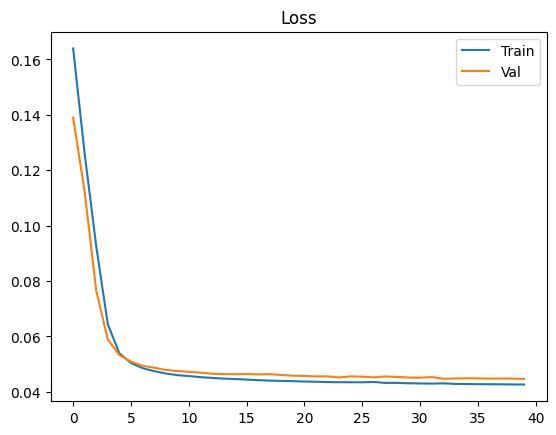

In [6]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

model = Model()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000001)

loss_fn = nn.MSELoss()

combined_history = train(model, X_train, y_train, X_val, y_val,epochs=40)

plt.plot(combined_history[:,0], label="Train")
plt.plot(combined_history[:,1], label="Val")
plt.title('Loss')
plt.legend()
plt.show()

### Evaluate Model

Train Loss:	 0.042626420107803174
Val Loss:	 0.044617777317762376
Test Loss:	 0.0432054163441062

Test MAE:	 0.1319543960111584
Test RMSE:	 0.19714577658681914


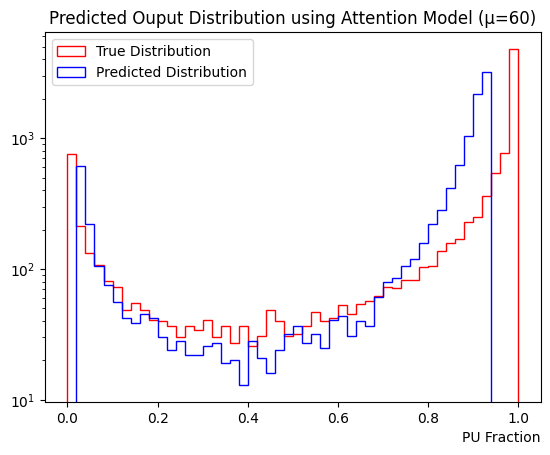

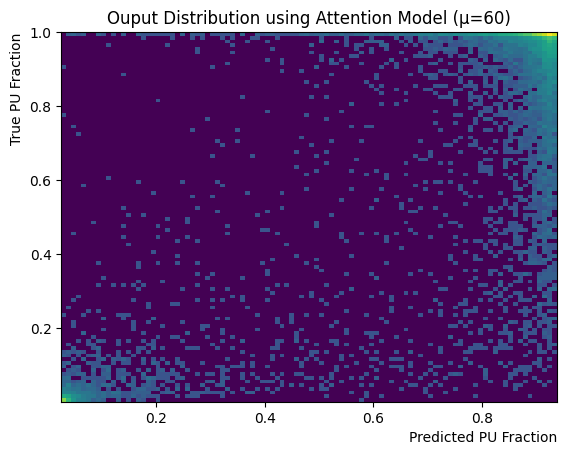

In [11]:
model.eval()
cumulative_loss_test = 0
cumulative_MSE_test = 0
cumulative_BCE_test = 0
predicted_labels = []
true_labels = []
binary_pred = []
binary_true = []

num_test = len(X_test)
for i in range(num_test):
    output, jet_weights, trk_weights, cross_weights = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))
    
    loss=loss_fn(output, y_test[i].to(device))
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
        
    for j in range(output.shape[0]): 
        predicted_labels.append(float(output[j][0].detach().cpu().numpy()))
        true_labels.append(float(y_test[i][j][0].detach().numpy()))
    
cumulative_loss_test = cumulative_loss_test / num_test
    
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)
print()
print("Test MAE:\t", mean_absolute_error(true_labels, predicted_labels))
print("Test RMSE:\t", root_mean_squared_error(true_labels, predicted_labels))

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()

plt.title("Ouput Distribution using Attention Model (\u03BC=60)")
plt.hist2d(predicted_labels,true_labels, bins=100,norm=mcolors.PowerNorm(0.2))
plt.xlabel('Predicted PU Fraction',loc='right')
plt.ylabel('True PU Fraction',loc='top')
plt.show()

### Visualize Attention Scores

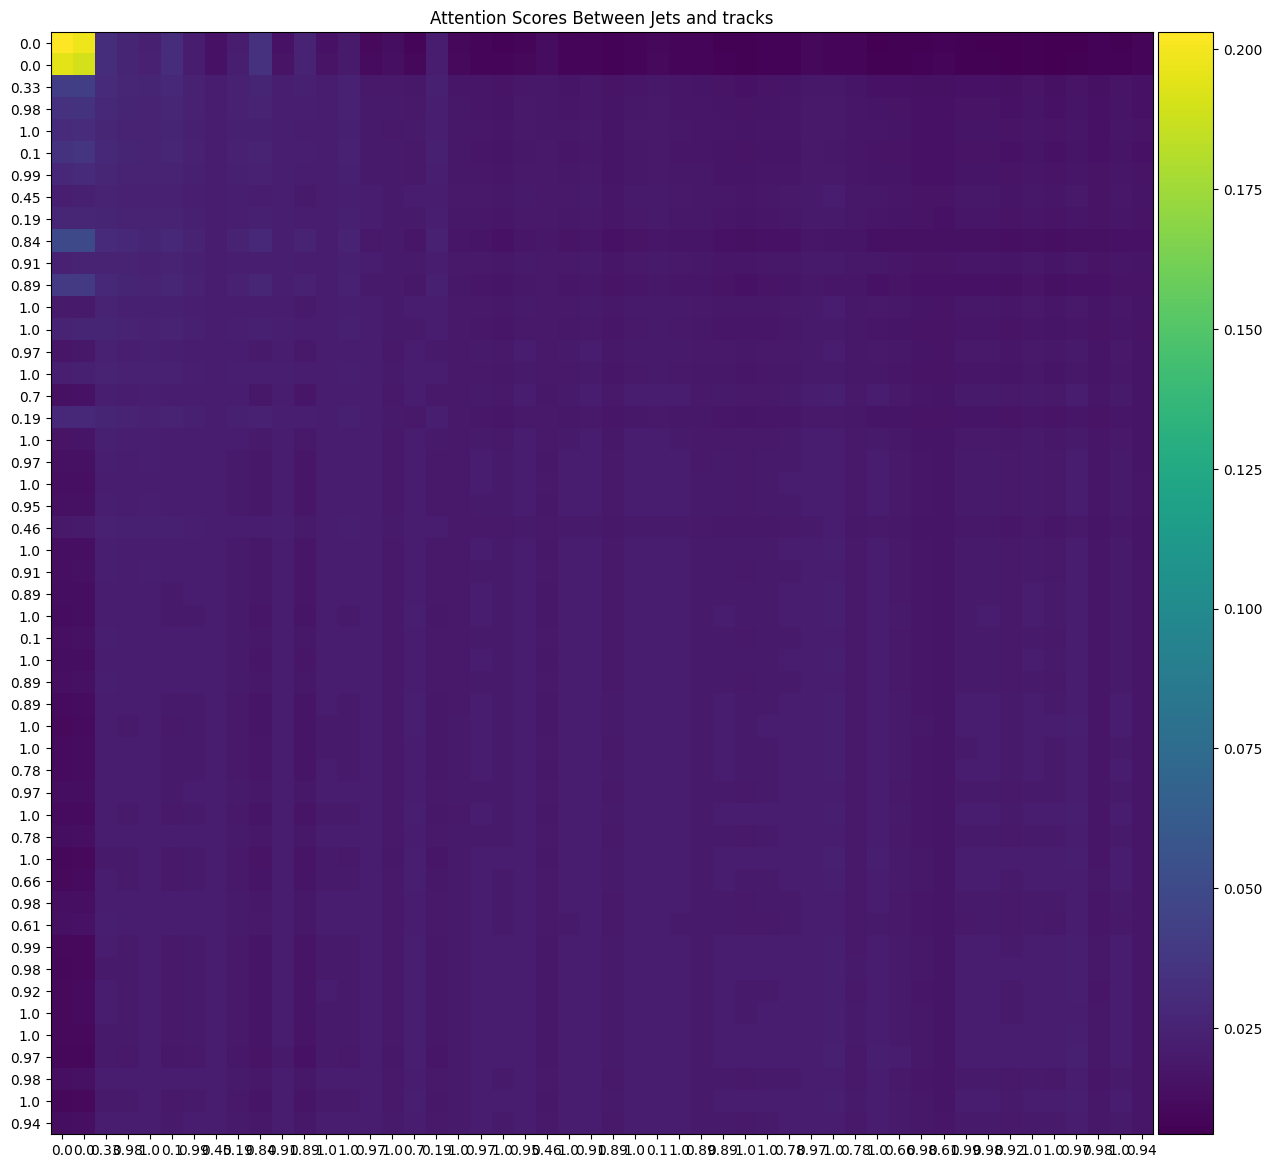

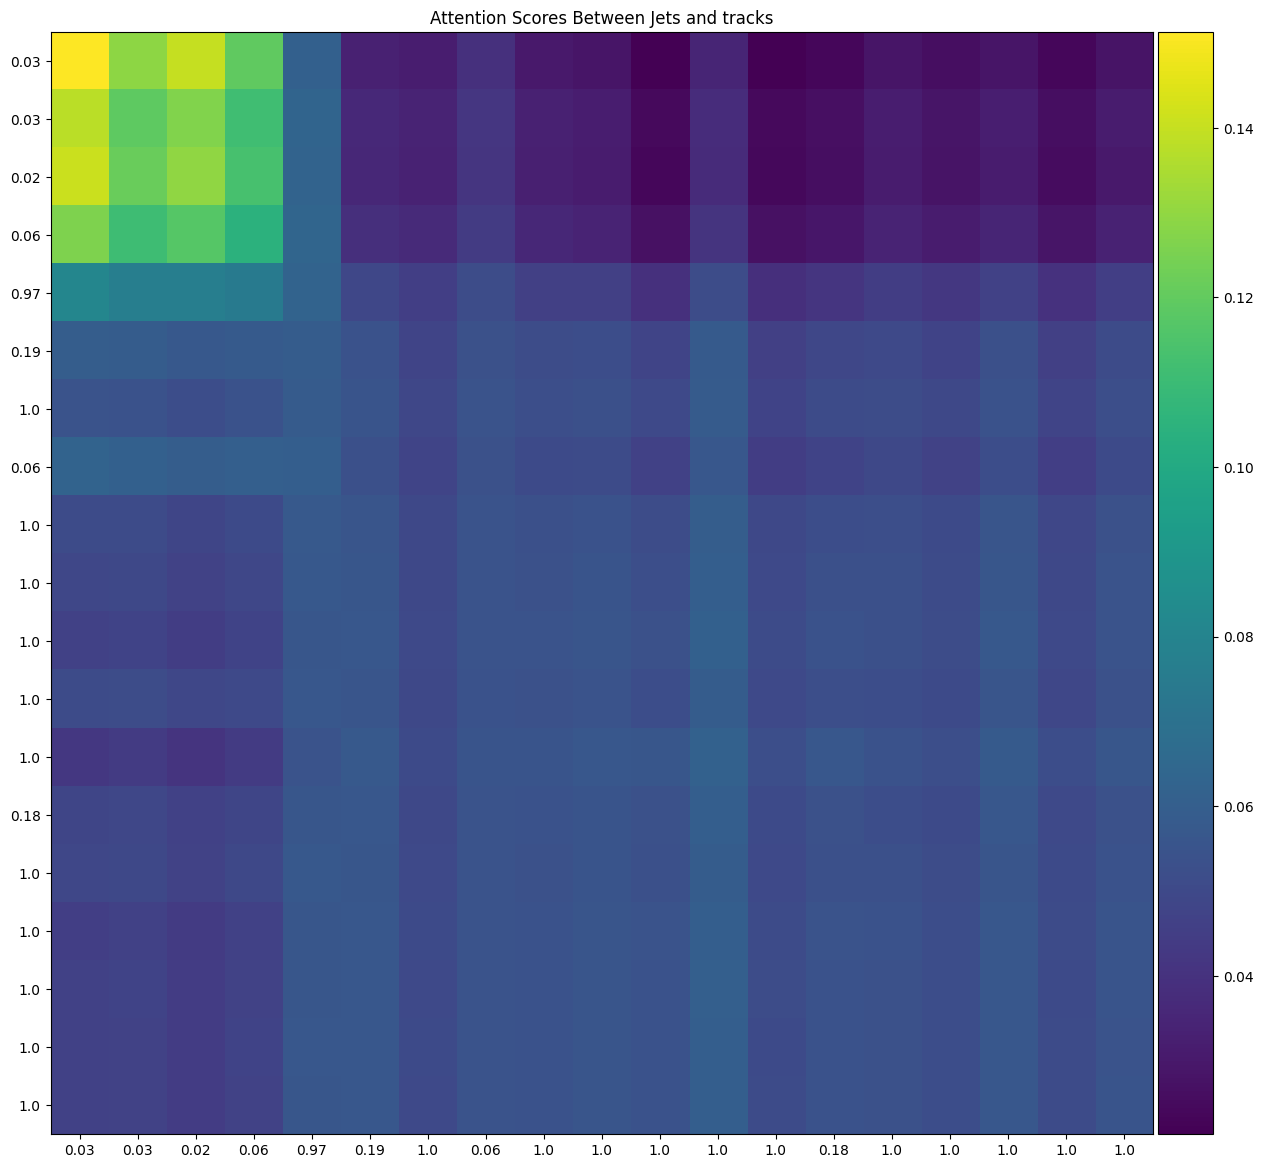

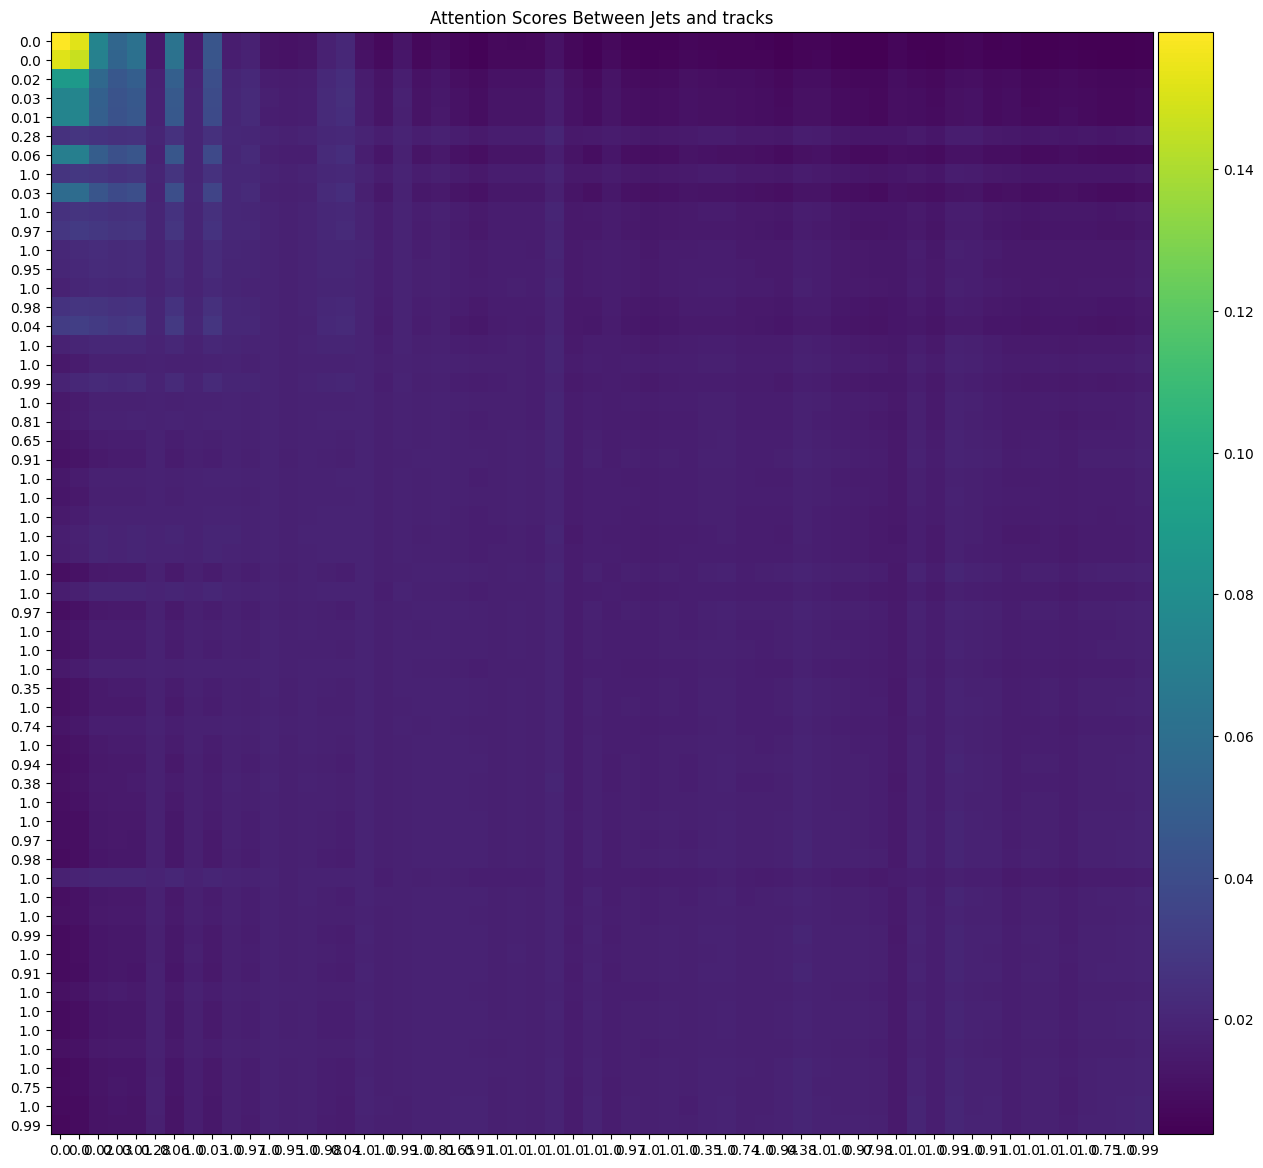

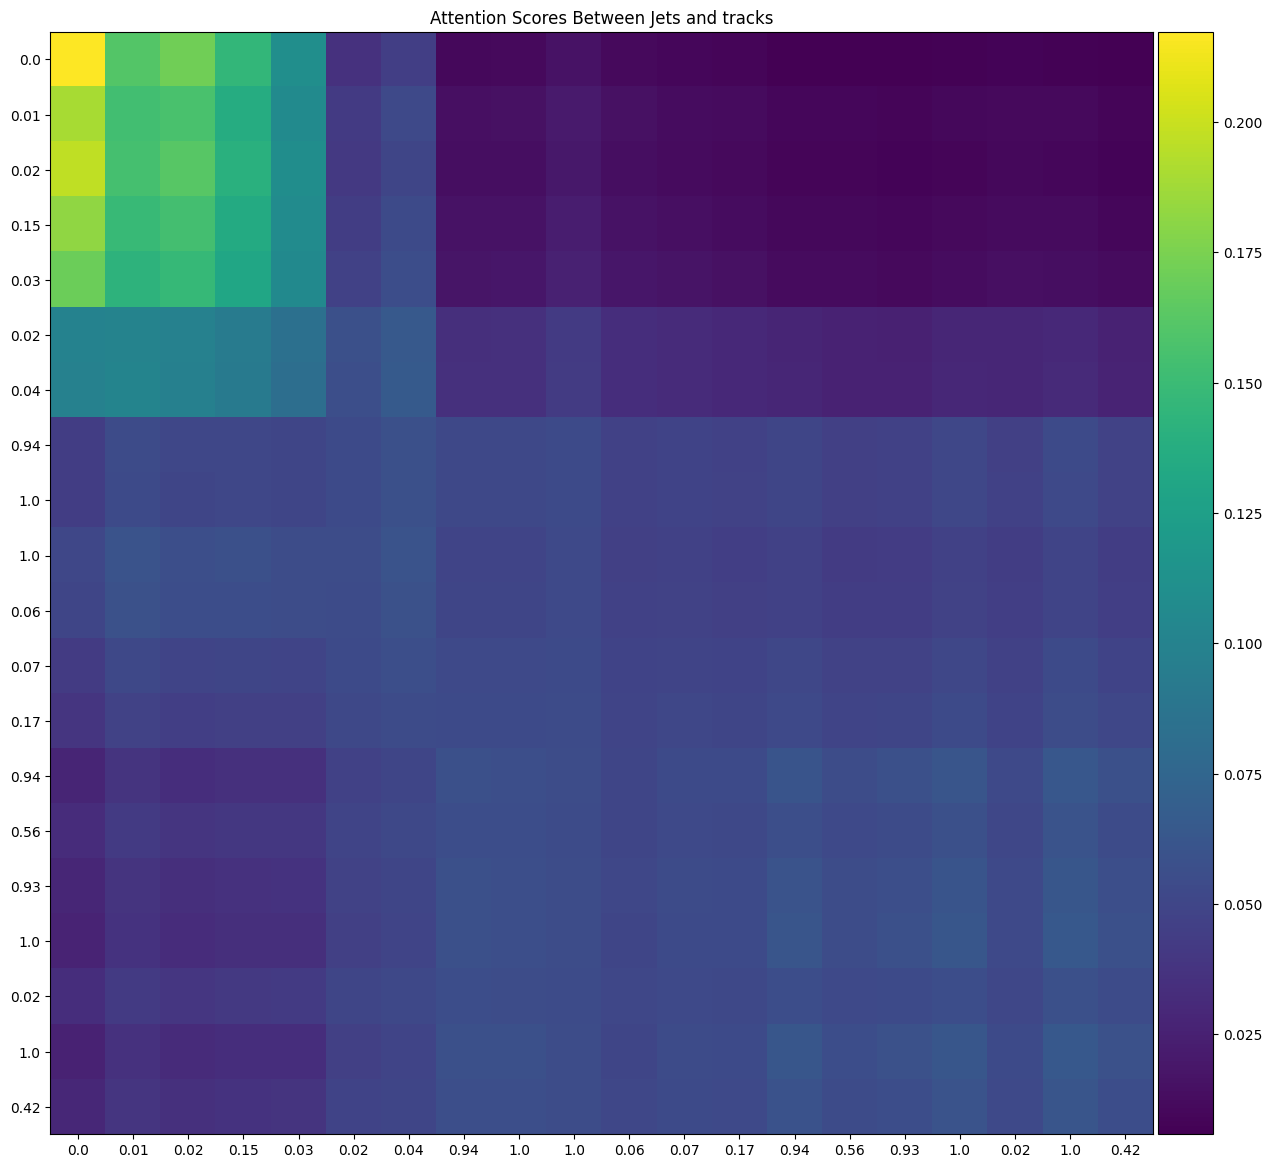

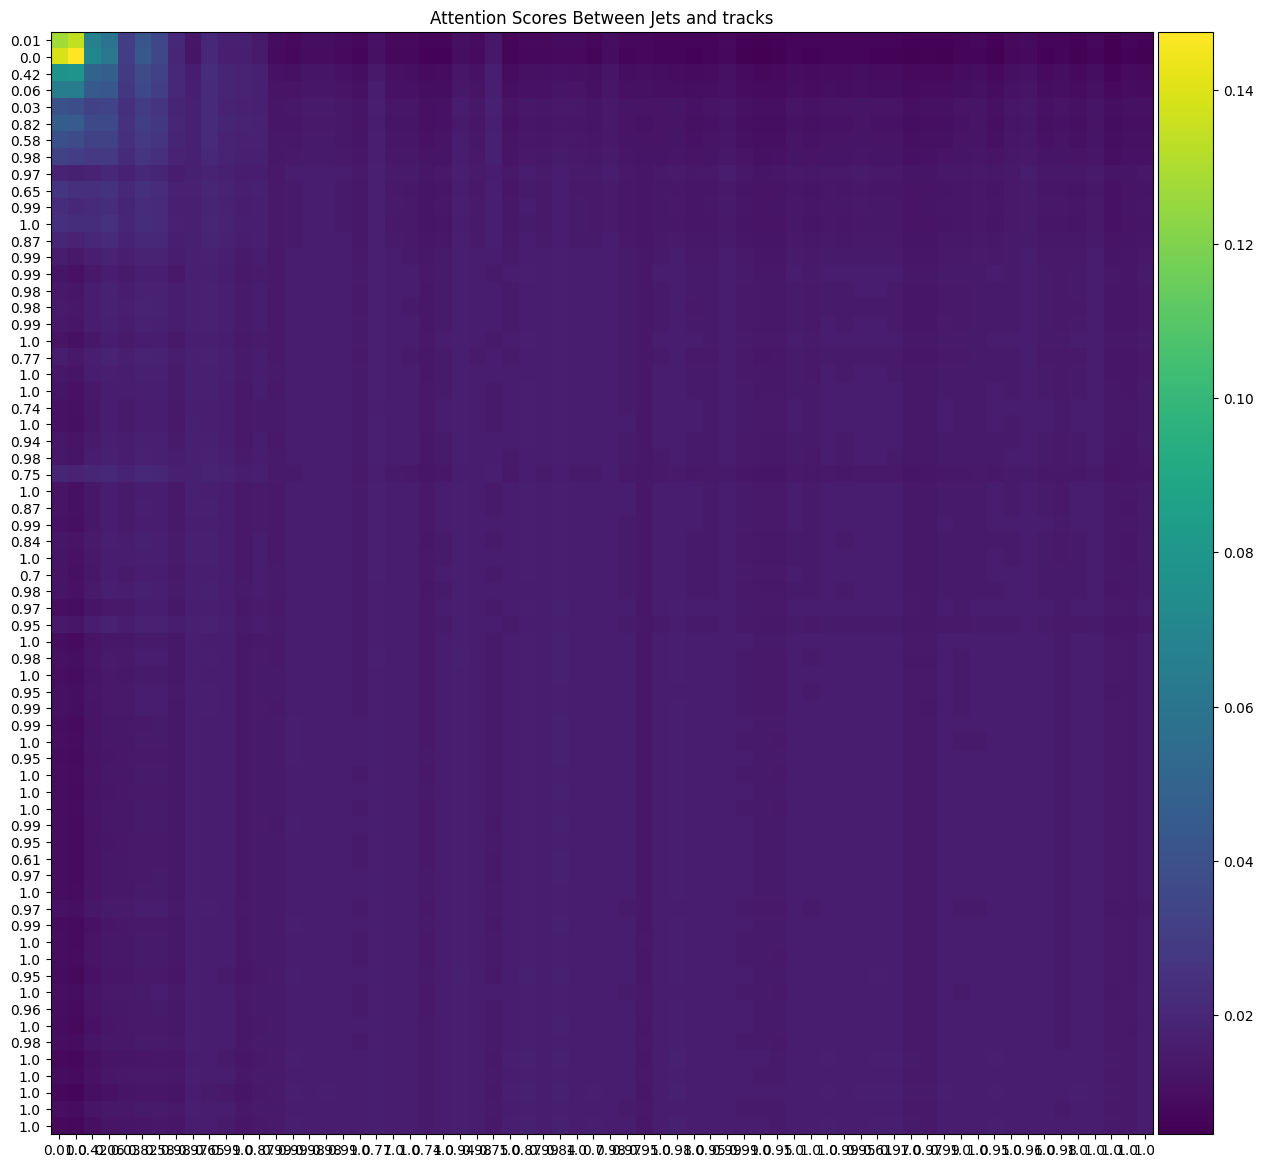

In [13]:
plot_events=5
for i in range(plot_events):
    # Get Model Predictions
    model.eval()
    output, jet_weights, trk_weights, cross_weights = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))
    
    num_jets = len(output)
    
    ticks = [x for x in range(num_jets)]
    jet_labels= [round(float(label.detach().cpu().numpy()[0]),2) for label in y_test[i]]   

    fig, (ax1) = plt.subplots(1, 1, figsize=(15,15))
    im0 = ax1.imshow(jet_weights.detach().cpu().numpy())
    ax1.set_xticks(ticks, jet_labels)
    ax1.set_yticks(ticks, jet_labels)
    ax1.set_title("Attention Scores Between Jets and tracks")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')